##### 캠으로 촬영하여 얼굴 인식 => 토끼 귀 그려주기
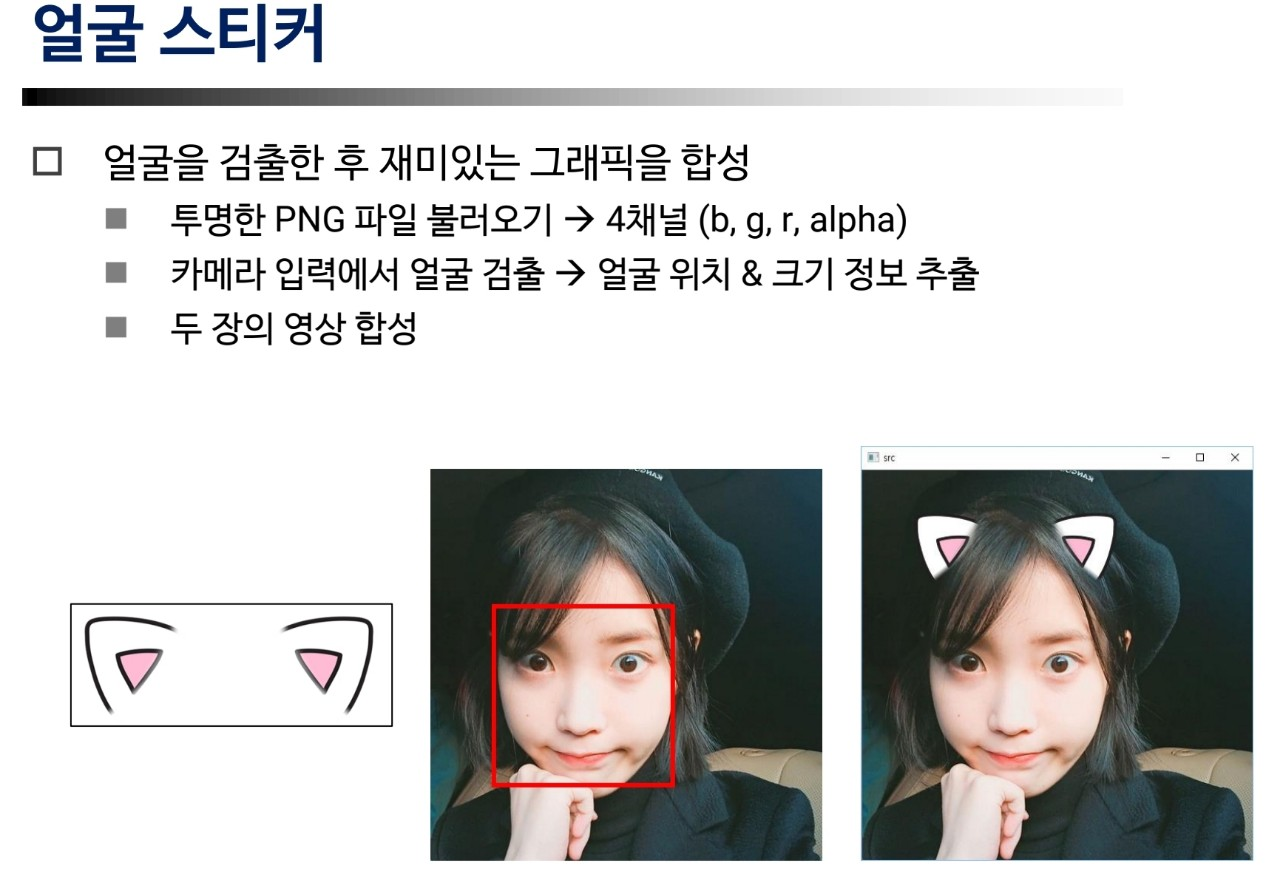

In [1]:
import sys
import numpy as np
import cv2


def overlay(frame, cat, pos):
    if pos[0] < 0 or pos[1] < 0:
        return

    if pos[0] + cat.shape[1] > frame.shape[1] or pos[1] + cat.shape[0] > frame.shape[0]:
        return

    sx = pos[0]
    ex = pos[0] + cat.shape[1]
    sy = pos[1]
    ey = pos[1] + cat.shape[0]

    img1 = frame[sy:ey, sx:ex]  # shape=(h, w, 3)
    img2 = cat[:, :, 0:3]       # shape=(h, w, 3)
    alpha = 1. - (cat[:, :, 3] / 255.)  # shape=(h, w)
    #ww = np.stack((alpha,)*3, axis=-1)

    img1[:, :, 0] = (img1[:, :, 0] * alpha + img2[:, :, 0] * (1. - alpha)).astype(np.uint8)
    img1[:, :, 1] = (img1[:, :, 1] * alpha + img2[:, :, 1] * (1. - alpha)).astype(np.uint8)
    img1[:, :, 2] = (img1[:, :, 2] * alpha + img2[:, :, 2] * (1. - alpha)).astype(np.uint8)
    #img1 = (img1 * ww + img2 * (1. - ww)).astype(np.uint8)


model = 'opencv_face_detector_uint8.pb'
config = 'opencv_face_detector.pbtxt'

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print('Camera open failed!')
    sys.exit()

net = cv2.dnn.readNet(model, config)

if net.empty():
    print('Net open failed!')
    sys.exit()

cat = cv2.imread('cat.png', cv2.IMREAD_UNCHANGED)

if cat is None:
    print('Image open failed!')
    sys.exit()

while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    # DNN모델을 통해 얼굴 객체 검출
    blob = cv2.dnn.blobFromImage(frame, 1, (300, 300), (104, 177, 123))
    net.setInput(blob)
    detect = net.forward()

    (h, w) = frame.shape[:2]
    detect = detect[0, 0, :, :]

    for i in range(detect.shape[0]):
        confidence = detect[i, 2]
        if confidence < 0.5:
            break

        x1 = int(detect[i, 3] * w + 0.5)
        y1 = int(detect[i, 4] * h + 0.5)
        x2 = int(detect[i, 5] * w + 0.5)
        y2 = int(detect[i, 6] * h + 0.5)

        fx = (x2 - x1) / cat.shape[1]
        cat2 = cv2.resize(cat, (0, 0), fx=fx, fy=fx)
        pos = (x1, y1 - (y2 - y1) // 4)
        #cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0))

        overlay(frame, cat2, pos)

    cv2.imshow('frame', frame)

    if cv2.waitKey(1) == 27:
        cap.release()
        break

cv2.destroyAllWindows()

__영상을 통해 얼굴을 인식 후, 특정 위치에 토끼 귀를 그려줌__